<center> <h1> CmdStanPy goes to the Women's World Cup! </h1> </center>

Some intro and some pics

<h2> 1. Importing the Packages and Data! </h2>

In [14]:
import cmdstanpy
import pandas as pd
from cmdstanpy import Model, StanFit
import ujson as json

We have two data files: the first one gives us information upto the quarterfinals:

In [15]:
matches = pd.read_csv('womens_world_cup_2019.csv')
matches.head()

,date,match_list,team_1,team_2,score_1,score_2
0,2019-06-07,France vs South Korea,France,South Korea,4.0,0.0
1,2019-06-08,Germany vs China,Germany,China,1.0,0.0
2,2019-06-08,Spain vs South Africa,Spain,South Africa,3.0,1.0
3,2019-06-08,Norway vs Nigeria,Norway,Nigeria,3.0,0.0
4,2019-06-09,Australia vs Italy,Australia,Italy,1.0,2.0


The second one is a list of the countries that participated in the decreasing order of "ability" prior to the tournament. This would be our **prior** here.<br>

We use the "soccer power index", abbreviated here as "spi", as determined at [538 by Nate Silver](https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/). In the stan model, these feature as "prior_score" in the input and as "ability" in the model.

In [16]:
countries = pd.read_csv('country_prior.csv')
countries.head()

,country,spi
0,USA,97.20623
1,France,95.31747
2,Germany,94.17161
3,Australia,93.13200
4,Netherlands,92.70844


We're going to rescale the prior here such that they have a mean of 0! (Ahem, floating points notwithstanding.)

In [17]:
import numpy as np
mean = np.mean(countries['spi'])
std = np.std(countries['spi'])

#Rescaling the prior!
countries['prior_score'] = [(x - mean)/std for x in countries['spi']]

In [18]:
country_mapping = countries.country.to_dict()
country_mapping = {k:v+1 for v,k in country_mapping.items()}

<h2> 2. Inputting the Data to CmdStanPy </h2>

The input data for the model needs to be in a dictionary format with the following keys: <br>

1. I: The number of teams <br>
2. N: The number of matches played <br>
3. team_1: A column of the "first" team <br>
4. team_2: A column of the "second" team <br>
5. prior_score: The countries' prior scores (i.e., spi's before the tournament) sorted in the descending order <br>

In [21]:
N = len(matches)
I = len(countries)
mydict = dict({'I': I,
               'N': N,
                'team_1': matches['team_1'].values,
               'team_2': matches['team_2'].values,
               'score_1': matches['score_1'].values,
               'score_2': matches['score_2'].values,
              'prior_score': countries['prior_score'].values})

We're now going to refer to the teams by a number that represents their pre-tournament ranking. To do that we first define a dictionary where the keys are the country names and the values are the team ranking.

In [22]:
#Replace team names by their rankings;
mydict['team_1'] = [ country_mapping.get(x) for x in mydict['team_1']]
mydict['team_2'] = [ country_mapping.get(x) for x in mydict['team_2']]

In [24]:
stan_wc = Model(stan_file='worldcup_rep_ag.stan')
stan_wc.compile()
stan_wc

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/nitya/Work/test_tutorial/worldcup_rep_ag


Model(name=worldcup_rep_ag,  stan_file="worldcup_rep_ag.stan", exe_file="/Users/nitya/Work/test_tutorial/worldcup_rep_ag")

In [25]:
worldcup_fit = stan_wc.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [26]:
worldcup_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpytup5upt/stan-worldcup_rep_ag-draws-1-x8xhjj7x.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpytup5upt/stan-worldcup_rep_ag-draws-2-0b9rfnyx.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpytup5upt/stan-worldcup_rep_ag-draws-3-zv1pkrbj.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpytup5upt/stan-worldcup_rep_ag-draws-4-9dz_2m0b.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [27]:
df = worldcup_fit.summary().round(decimals = 2)
df

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-52.49,0.30,6.76,-64.67,-51.83,-42.50,515.66,354.92,1.0
beta,0.94,0.01,0.26,0.52,0.94,1.35,2278.94,1568.54,1.0
alpha[1],0.97,0.01,0.67,-0.14,0.99,2.04,3100.05,2133.69,1.0
alpha[2],0.32,0.01,0.63,-0.71,0.33,1.34,4519.41,3110.59,1.0
alpha[3],0.41,0.01,0.66,-0.68,0.40,1.49,3815.42,2626.06,1.0
alpha[4],-0.20,0.01,0.67,-1.26,-0.20,0.92,4647.03,3198.43,1.0
alpha[5],0.46,0.01,0.64,-0.62,0.46,1.50,3719.82,2560.25,1.0
alpha[6],0.56,0.01,0.70,-0.62,0.58,1.68,3222.25,2217.79,1.0
alpha[7],-0.75,0.01,0.70,-1.94,-0.73,0.35,3306.17,2275.55,1.0



What you see above above is a dataframe of the summary of the "stanfit" object:

From the Stan webpage: (https://mc-stan.org/rstan/reference/stanfit-class.html)<br>
An object of class stanfit contains the output derived from fitting a Stan model as returned by the top-level function stan or the lower-level methods sampling and vb (which are defined on class stanmodel). Many methods (e.g., print, plot, summary) are provided for summarizing results and various access methods also allow the underlying data (e.g., simulations, diagnostics) contained in the object to be retrieved.

The summary method returns a named list with elements summary and c_summary, which contain summaries for for all chains merged and individual chains, respectively. Included in the summaries are quantiles, means, standard deviations (sd), effective sample sizes (n_eff), and split Rhats (the potential scale reduction derived from all chains after splitting each chain in half and treating the halves as chains). For the summary of all chains merged, Monte Carlo standard errors (se_mean) are also reported.

<h2> 3. Interpreting and Evaluating the Model </h2>

In [28]:
dft = df.transpose()
ability_filter = [col for col in dft if col.startswith('ability')]
yrep_filter = [col for col in dft if col.startswith('y_rep')]

In [29]:
#Abilities
abilities = dft[ability_filter]

#Team Differentials
td = dft[yrep_filter]

In [30]:
abilities

name,ability[1],ability[2],ability[3],ability[4],ability[5],ability[6],ability[7],ability[8],ability[9],ability[10],...,ability[15],ability[16],ability[17],ability[18],ability[19],ability[20],ability[21],ability[22],ability[23],ability[24]
Mean,2.01,1.28,1.29,0.67,1.27,1.39,0.17,0.66,0.61,1.02,...,-1.05,0.55,-0.62,-0.62,-1.40,-2.09,-0.84,-2.55,-1.11,-0.94
MCSE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.03
StdDev,0.63,0.56,0.57,0.59,0.57,0.62,0.59,0.57,0.57,0.56,...,0.79,0.62,0.61,0.58,0.67,0.75,0.75,0.78,0.67,0.90
5%,1.01,0.37,0.38,-0.32,0.34,0.42,-0.82,-0.30,-0.32,0.13,...,-2.39,-0.44,-1.65,-1.58,-2.51,-3.36,-2.01,-3.86,-2.17,-2.39
50%,1.98,1.27,1.28,0.69,1.25,1.37,0.18,0.66,0.61,1.01,...,-1.05,0.54,-0.61,-0.63,-1.38,-2.07,-0.86,-2.52,-1.12,-0.93
95%,3.08,2.20,2.25,1.63,2.23,2.44,1.10,1.62,1.52,1.96,...,0.22,1.57,0.38,0.34,-0.35,-0.90,0.43,-1.29,-0.01,0.52
N_Eff,2183.10,4846.62,3791.62,3950.58,3017.68,2108.63,3586.48,4443.07,4841.52,3112.56,...,1409.47,2522.07,3908.89,3979.89,3402.13,1595.77,1774.80,2155.97,3183.45,1231.57
N_Eff/s,1502.57,3335.80,2609.67,2719.08,2076.99,1451.32,2468.48,3058.05,3332.29,2142.30,...,970.10,1735.88,2690.39,2739.26,2341.60,1098.33,1221.55,1483.90,2191.09,847.66
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [31]:
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],...,y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.35,1.33,1.85,0.91,0.09,2.75,2.26,-1.08,1.27,-1.68,...,2.01,0.66,-1.56,0.35,0.59,1.10,-1.08,-0.73,-0.71,0.28
MCSE,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.04,0.02,0.03,...,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
StdDev,1.69,1.61,1.62,1.63,1.64,1.69,1.65,1.77,1.62,1.68,...,1.64,1.64,1.65,1.61,1.67,1.62,1.67,1.65,1.63,1.63
5%,-0.40,-1.30,-0.73,-1.75,-2.45,0.03,-0.30,-4.09,-1.40,-4.39,...,-0.67,-1.99,-4.16,-2.31,-2.19,-1.46,-3.71,-3.38,-3.35,-2.33
50%,2.37,1.33,1.88,0.91,0.06,2.76,2.24,-1.00,1.26,-1.68,...,2.02,0.65,-1.63,0.38,0.61,1.12,-1.11,-0.77,-0.71,0.24
95%,4.92,3.86,4.40,3.60,2.85,5.40,4.95,1.66,3.92,0.94,...,4.59,3.26,1.19,2.98,3.24,3.65,1.70,1.95,1.97,2.80
N_Eff,2989.70,4242.36,3707.42,4156.52,3718.61,3857.57,3803.46,2149.62,4480.36,4058.99,...,4463.01,3983.07,3714.10,3992.03,3718.25,3582.92,3288.25,3813.89,3679.96,4095.86
N_Eff/s,2057.73,2919.91,2551.72,2860.83,2559.42,2655.07,2617.82,1479.53,3083.71,2793.70,...,3071.77,2741.45,2556.32,2747.61,2559.18,2466.03,2263.22,2625.00,2532.82,2819.07
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<h3> Plots! </h3>

In [37]:
import matplotlib.pyplot as plt
df_teamdifferentials = pd.DataFrame({'midway': td.loc['50%'].values,
                                       'names':matches['match_list']})
df_teamdifferentials.loc[:, 'left'] = td.loc['5%'].values
df_teamdifferentials.loc[:, 'right'] = td.loc['95%'].values

In [38]:
actual_differentials = np.array([matches['score_1'][i]-matches['score_2'][i]  for i in range(len(matches))])

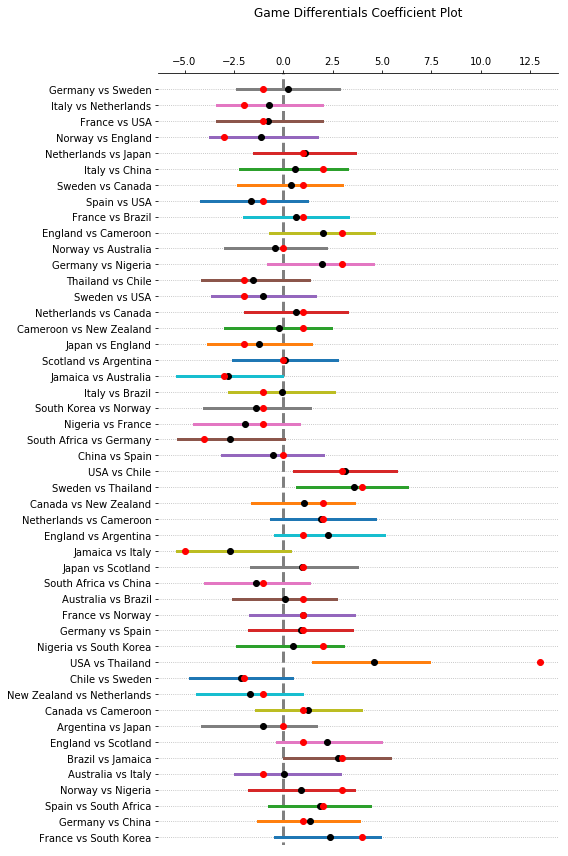

In [39]:
from coefplot import coefficient_plot

coefficient_plot(df_teamdifferentials['midway'], df_teamdifferentials['left'], 
                 df_teamdifferentials['right'], actual_differentials, 
                 names=df_teamdifferentials['names'],
                 title='Game Differentials Coefficient Plot')
plt.tight_layout()

In [40]:
df_abilities = pd.DataFrame({'midway': abilities.loc['50%'].values,
                                       'names': countries['country']})
df_abilities.loc[:, 'left'] = abilities.loc['5%'].values
df_abilities.loc[:, 'right'] = abilities.loc['95%'].values

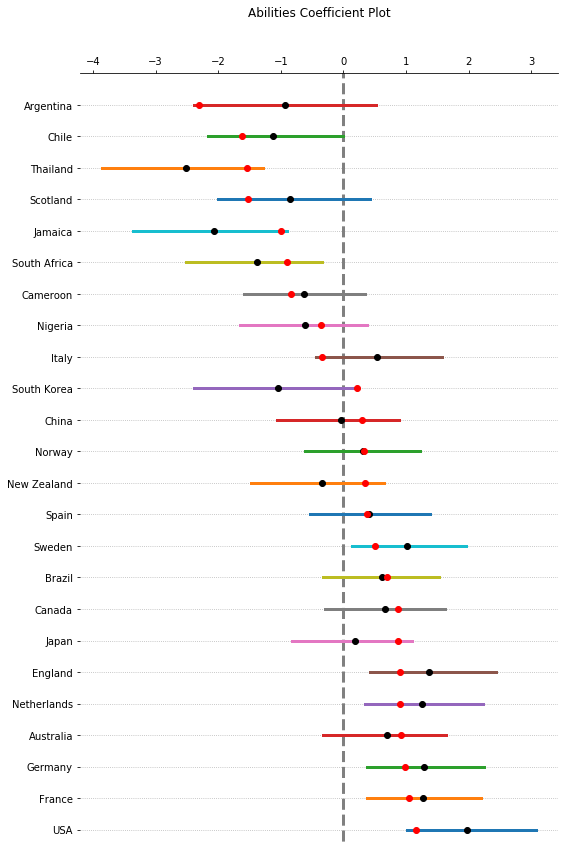

In [42]:
coefficient_plot(df_abilities['midway'], df_abilities['left'], 
                 df_abilities['right'], countries['prior_score'], 
                 names=df_abilities['names'],
                 title='Abilities Coefficient Plot')
plt.tight_layout()
#plt.savefig('/Users/nitya/Desktop/Predictions_abilities.png')
